In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from funcs.models import model_ND
from funcs.fitting import loss
from scipy.optimize import minimize

## Heat input function

In [13]:
func_Q_in = lambda x: (1 + 0.5*np.sin(2*np.pi*x/(3600*12))) #

We are able to recover the desired heat capacity, thermal conductivity and initial temperature even with pretty bad intial guesses. However, need to ensure intial guesses are at least on the right order of magnitude.

## 2 Segments

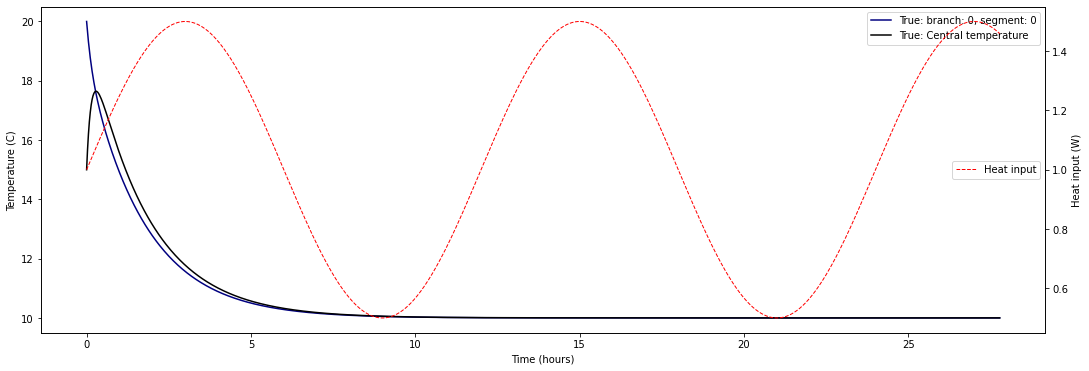

In [17]:
k = [800.0, 500.0]
c = [6e5, 2.5e6]
T = [15.0, 20.0]
true_params = np.array([*k, *c, *T])
iterations = 1000

T_out = np.full(iterations+1, 10)
Q_in = func_Q_in(times)

# Initialise class with system parameters
sys_nd = model_ND('True', k, c, T, T_out, Q_in)

# Run simulation. This recreates simple_model.ipynb showing that our generalised model works.
times = np.linspace(0, 10e4, iterations+1)
Ts_true = sys_nd.run(times=times)
fig, ax = sys_nd.plot()

In [18]:
# Initial guesses for scipy.optimize.minimize
k0 = [900.0, 400.0]
c0 = [7e5, 1e6]
T0 = [16.0, 19.0]
initial_params = np.array([*k0, *c0, *T0])

### Fit to entire data

	Initial			Estimated		Actual
k1:	900.00000		899.93791		800.00000
k2:	400.00000		398.31243		500.00000
c1:	700000.00000		700000.00025		600000.00000
c2:	1000000.00000		1000000.00036		2500000.00000
T1:	16.00000		16.31860		15.00000
T2:	19.00000		23.59060		20.00000
______________________________________________________
Percentage error:
k1:		12.49%		k2:		20.34%
c1:		16.67%		c2:		60.00%
T1_initial:	8.79%		T2_initial:	17.95%


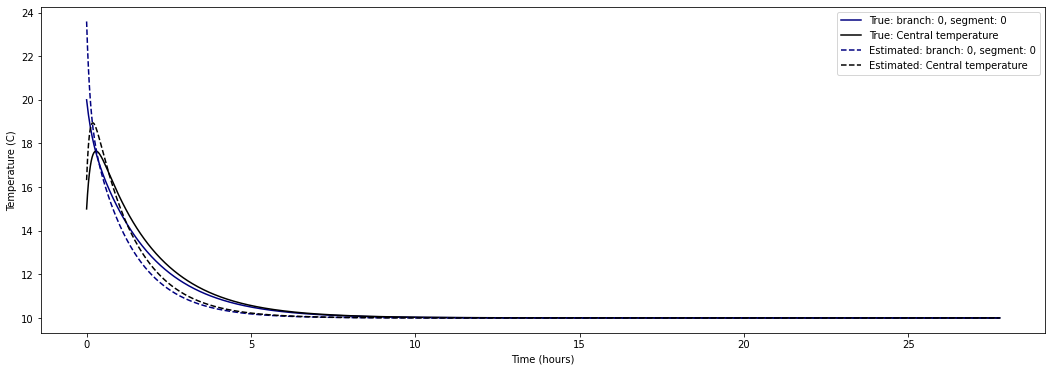

In [20]:
result = minimize(loss, x0=initial_params, tol=1e-3, args=('mse', times, Ts_true, T_out, Q_in), bounds=((1e2,1e3),(1e2,1e3),(1e5,1e6),(1e6,3e6),(10,30),(10,30)))
k_est, c_est, T_est = result['x'].reshape((3,2))
sys_est = model_ND('Estimated',k_est, c_est, T_est, T_out, heatinput)
Ts_est = sys_est.run(times=times)

fig, ax = sys_nd.plot(show_heating=False)
fig, ax = sys_est.plot(figax=(fig, ax), show_heating=False, ls='--')

frac_error = abs((result['x'] - true_params)/true_params * 100)
print('\tInitial\t\t\tEstimated\t\tActual\nk1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nk2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}'.format(*np.ravel([initial_params,result['x'],true_params],'F')))
print('_'*54)
print('Percentage error:\nk1:\t\t{:.2f}%\t\tk2:\t\t{:.2f}%\nc1:\t\t{:.2f}%\t\tc2:\t\t{:.2f}%\nT1_initial:\t{:.2f}%\t\tT2_initial:\t{:.2f}%'.format(*frac_error))

### Fit to first 80%, test loss on final 20%
> Note that blue shaded region shows performance of model on unseen data

In [22]:
idxs = 4*iterations//5

	Initial			Estimated		Actual
k1:	900.00000		899.93789		800.00000
k2:	400.00000		398.31013		500.00000
c1:	700000.00000		700000.00039		600000.00000
c2:	1000000.00000		1000000.00046		2500000.00000
T1:	16.00000		16.31820		15.00000
T2:	19.00000		23.59087		20.00000
______________________________________________________
Percentage error:
k1:		12.49%		k2:		20.34%
c1:		16.67%		c2:		60.00%
T1_initial:	8.79%		T2_initial:	17.95%


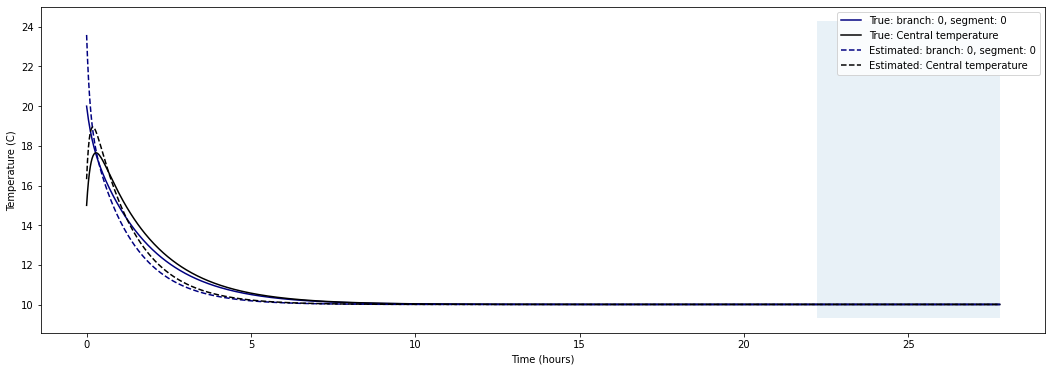

In [24]:
result = minimize(loss, x0=initial_params, tol=1e-3, args=('mse', times[:idxs], Ts_true[:,:,:idxs], T_out[:idxs], Q_in[:idxs]), bounds=((1e2,1e3),(1e2,1e3),(1e5,1e6),(1e6,3e6),(10,30),(10,30)))
k_est, c_est, T_est = result['x'].reshape((3,2))
sys_est = model_ND('Estimated',k_est, c_est, T_est, T_out, heatinput)
Ts_est = sys_est.run(times=times)

fig, ax = sys_nd.plot(show_heating=False)
fig, ax= sys_est.plot(figax=(fig, ax), show_heating=False, ls='--')
ax.fill_between(times[idxs:]/3600, *ax.get_ylim(), alpha=0.1)

frac_error = abs((result['x'] - true_params)/true_params * 100)
print('\tInitial\t\t\tEstimated\t\tActual\nk1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nk2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}'.format(*np.ravel([initial_params,result['x'],true_params],'F')))
print('_'*54)
print('Percentage error:\nk1:\t\t{:.2f}%\t\tk2:\t\t{:.2f}%\nc1:\t\t{:.2f}%\t\tc2:\t\t{:.2f}%\nT1_initial:\t{:.2f}%\t\tT2_initial:\t{:.2f}%'.format(*frac_error))

### Fit to first 20%, test loss on final 80%
> Note that blue shaded region shows performance of model on unseen data

In [25]:
idxs = 1*iterations//5

	Initial			Estimated		Actual
k1:	900.00000		895.40205		800.00000
k2:	400.00000		267.87184		500.00000
c1:	700000.00000		700000.03267		600000.00000
c2:	1000000.00000		1000000.03260		2500000.00000
T1:	16.00000		15.39169		15.00000
T2:	19.00000		21.36762		20.00000
______________________________________________________
Percentage error:
k1:		11.93%		k2:		46.43%
c1:		16.67%		c2:		60.00%
T1_initial:	2.61%		T2_initial:	6.84%


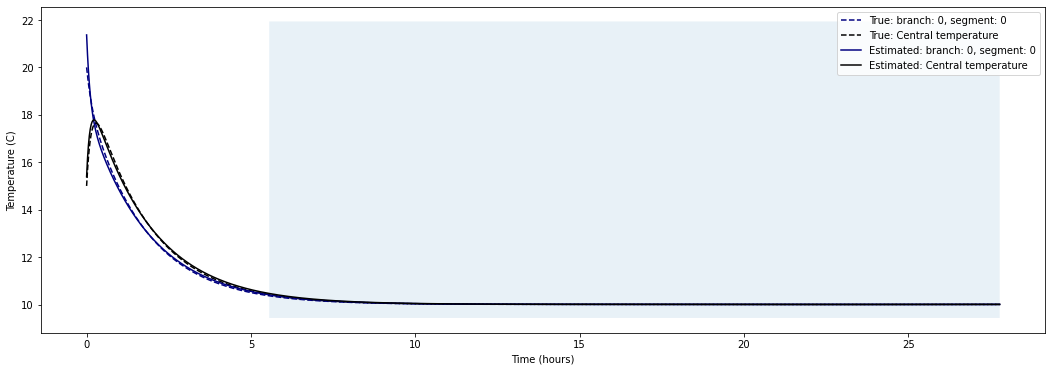

In [26]:
result = minimize(loss, x0=initial_params, tol=1e-3, args=('mse', times[:idxs], Ts_true[:,:,:idxs], T_out[:idxs], Q_in[:idxs]), bounds=((1e2,1e3),(1e2,1e3),(1e5,1e6),(1e6,3e6),(10,30),(10,30)))
k_est, c_est, T_est = result['x'].reshape((3,2))
sys_est = model_ND('Estimated',k_est, c_est, T_est, T_out, heatinput)
Ts_est = sys_est.run(times=times)

fig, ax = sys_nd.plot(ls='--', show_heating=False)
fig, ax= sys_est.plot(figax=(fig, ax), show_heating=False)
ax.fill_between(times[idxs:]/3600, *ax.get_ylim(), alpha=0.1)

frac_error = abs((result['x'] - true_params)/true_params * 100)
print('\tInitial\t\t\tEstimated\t\tActual\nk1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nk2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}'.format(*np.ravel([initial_params,result['x'],true_params],'F')))
print('_'*54)
print('Percentage error:\nk1:\t\t{:.2f}%\t\tk2:\t\t{:.2f}%\nc1:\t\t{:.2f}%\t\tc2:\t\t{:.2f}%\nT1_initial:\t{:.2f}%\t\tT2_initial:\t{:.2f}%'.format(*frac_error))

### Looking at error as a function of test/train split:

In [28]:
splits = np.array([0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 0.9])
idxs = (splits*iterations).astype('int')
frac_errors = []
for idx in idxs:
    result = minimize(loss, x0=initial_params, tol=1e-3, args=('mse', times[:idx], Ts_true[:,:,:idx], T_out[:idx], Q_in[:idx]), bounds=((1e2,1e3),(1e2,1e3),(1e5,1e6),(1e6,3e6),(10,30),(10,30)))
    k_est, c_est, T_est = result['x'].reshape((3,2))
    frac_error = abs((result['x'] - true_params)/true_params * 100) 
    frac_errors.append(frac_error)

In [29]:
frac_errors = np.array(frac_errors)

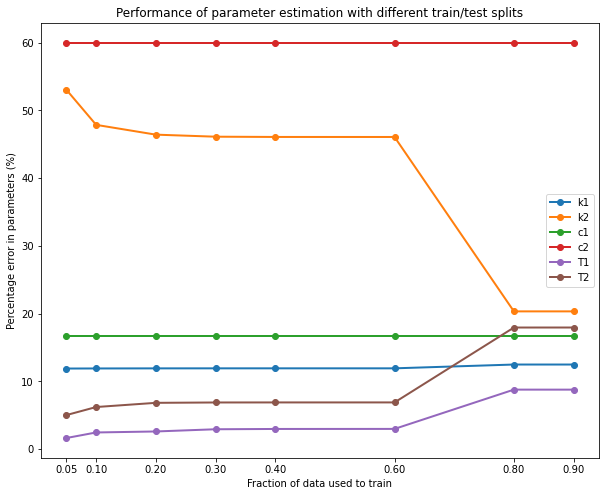

In [30]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
ax.plot(splits, frac_errors, lw=2, marker='o');
ax.legend(['k1','k2','c1','c2','T1','T2'])
ax.set_xticks(splits)
ax.set(xlabel='Fraction of data used to train', ylabel='Percentage error in parameters (%)', title='Performance of parameter estimation with different train/test splits');